In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim

from scipy.io import loadmat
from scipy.signal import hilbert
from skimage.transform import resize
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from torch.utils.data import DataLoader


Matplotlib is building the font cache; this may take a moment.


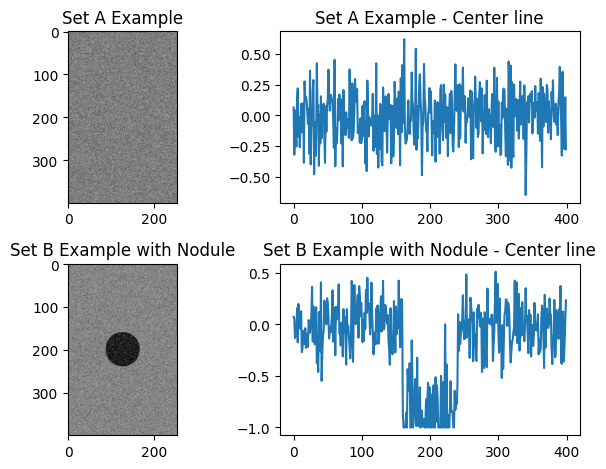

In [13]:
import matplotlib.pyplot as plt
# Creating dummy training data
def generate_noise_image(scale=0.2):
    return np.clip(np.random.normal(loc=0.0, scale=scale, size=(height, width)), -1, 1)
num_A = 1000
height = 400
width = 254

set_A = np.array([generate_noise_image() for _ in range(num_A)])
labels_A = np.zeros(num_A)

# Creating dummy testing data
def add_nodule(image, strength=0.8, radius=40):
    center_y, center_x = height // 2, width // 2
    Y, X = np.ogrid[:height, :width]
    mask = (Y - center_y)**2 + (X - center_x)**2 <= radius**2
    
    # Add nodule noise (Gaussian, centered at -strength)
    nodule = np.random.normal(loc=-strength, scale=0.2, size=image.shape)
    image[mask] += nodule[mask]
    
    return np.clip(image, -1, 1)

num_B = 500
set_B1 = np.array([generate_noise_image() for _ in range(num_B)])
labels_B1 = np.zeros(num_B)
set_B2 = np.array([add_nodule(generate_noise_image()) for _ in range(num_B)])
labels_B2 = np.ones(num_B)
set_B = np.concatenate((set_B1, set_B2), axis=0)
labels_B = np.concatenate((labels_B1, labels_B2), axis=0)

# Show examples
plt.subplot(2, 2, 1)
plt.imshow(set_A[0], cmap='gray')
plt.title('Set A Example')
plt.subplot(2, 2, 2)
plt.plot(set_A[0, :, width//2])
plt.title('Set A Example - Center line')
plt.subplot(2, 2, 3)
plt.imshow(set_B[-1], cmap='gray')
plt.title('Set B Example with Nodule')
plt.subplot(2, 2, 4)
plt.plot(set_B[-1, :, width//2])
plt.title('Set B Example with Nodule - Center line')
plt.tight_layout()
plt.show()

In [71]:
def prepare_loaders(data, batch_size=128, shuffle=False, zeroesonly=False):
    [X, y] = data

    # Transform 2D data in 1D signals
    data_A_transposed = np.transpose(X, [0, 2, 1]) 
    # Reshape to merge samples and columns
    data_A_1d = data_A_transposed.reshape(-1, height) 
    # Add channel dimension to get shape 
    data_A_1d = np.expand_dims(data_A_1d, 1) 
    print("New shape:", data_A_1d.shape)
        
    X = data_A_1d.astype(np.float32)
    y = np.repeat(y, width)
    
    dataset = list(zip(X, y))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

batch_size  = 128
trainloader = prepare_loaders([set_A, labels_A], batch_size=batch_size, shuffle=True)
valloader   = prepare_loaders([set_B, labels_B], batch_size=1, shuffle=False)
print('Done.')

New shape: (254000, 1, 400)
New shape: (254000, 1, 400)
Done.


In [ ]:
#%% Model and Training functions
#Check CUDA availability
global device

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using', device)

'''
Code for the network is based on Suvon et al's CardioVAE: 
https://github.com/Shef-AIRE/AI4Cardiothoracic-CardioVAE/blob/main/CardioVAE.ipynb
Please refer to the original paper for more details and references.
'''
class ProductOfExperts(nn.Module):
    """Return parameters for product of independent experts.
    See https://arxiv.org/pdf/1410.7827.pdf for equations.

    @param mu: M x D for M experts
    @param logvar: M x D for M experts
    """
    def forward(self, mu, logvar, eps=1e-8):
        var       = torch.exp(logvar) + eps
        # precision of i-th Gaussian expert at point x
        T         = 1. / (var + eps)
        pd_mu     = torch.sum(mu * T, dim=0) / torch.sum(T, dim=0)
        pd_var    = 1. / torch.sum(T, dim=0)
        pd_logvar = torch.log(pd_var + eps)
        return pd_mu, pd_logvar

def prior_expert(size, use_cuda=False):
    """Universal prior expert. Here we use a spherical
    Gaussian: N(0, 1).

    @param size: integer
                 dimensionality of Gaussian
    @param use_cuda: boolean [default: False]
                     cast CUDA on variables
    """
    mu     = Variable(torch.zeros(size))
    logvar = Variable(torch.zeros(size))
    if use_cuda:
        mu, logvar = mu.cuda(), logvar.cuda()
    return mu, logvar
    
class ECGVAEEncoder(nn.Module):
    def __init__(self, input_dim=60000, latent_dim=256):
        super(ECGVAEEncoder, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, stride=2, padding=1)
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(in_features=64 * (input_dim // 8), out_features=latent_dim)  # Adjusted for stride=2, 3 layers
        self.fc_logvar = nn.Linear(in_features=64 * (input_dim // 8), out_features=latent_dim)
        # self.fc_mu = nn.Linear(in_features= 26048, out_features=latent_dim)  # Hard-coded value for signals of length = 3249
        # self.fc_logvar = nn.Linear(in_features= 26048, out_features=latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.flatten(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

# ECG Modality Decoder
class ECGVAEDecoder(nn.Module):
    def __init__(self, latent_dim=256, output_dim=60000):
        super(ECGVAEDecoder, self).__init__()
        self.fc = nn.Linear(in_features=latent_dim, out_features=64 * (output_dim // 8))
        self.convtrans1 = nn.ConvTranspose1d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.convtrans2 = nn.ConvTranspose1d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.convtrans3 = nn.ConvTranspose1d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.relu = nn.ReLU()
        self.output_activation = nn.Identity()  # Suitable for standardized data

    def forward(self, z):
        z = self.fc(z)
        z = z.view(-1, 64, z.size(1) // 64)  # Adjust the reshape for proper dimensions
        z = self.relu(self.convtrans1(z))
        z = self.relu(self.convtrans2(z))
        z = self.output_activation(self.convtrans3(z))
        return z

class CardioVAE(nn.Module):
    def __init__(self, image_input_channels=1, ecg_input_dim=60000, latent_dim=256):
        super(CardioVAE, self).__init__()
        self.ecg_encoder = ECGVAEEncoder(ecg_input_dim, latent_dim)
        self.ecg_decoder = ECGVAEDecoder(latent_dim, ecg_input_dim)

        self.experts       = ProductOfExperts()
        self.n_latents     = latent_dim

    def reparametrize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
          return mu

    def forward(self, image=None, ecg=None):
        mu, logvar = self.infer(image, ecg)
        # reparametrization trick to sample
        z          = self.reparametrize(mu, logvar)
        # reconstruct inputs based on that gaussian
        img_recon  = 0#self.image_decoder(z)
        ecg_recon  = self.ecg_decoder(z)
        return img_recon, ecg_recon, mu, logvar

    def infer(self, image=None, ecg=None): 
        batch_size = image.size(0) if image is not None else ecg.size(0)
        use_cuda   = next(self.parameters()).is_cuda  # check if CUDA
        # initialize the universal prior expert
        mu, logvar = prior_expert((1, batch_size, self.n_latents), 
                                  use_cuda=use_cuda)
        if image is not None:
            img_mu, img_logvar = self.image_encoder(image)
            mu     = torch.cat((mu, img_mu.unsqueeze(0)), dim=0)
            logvar = torch.cat((logvar, img_logvar.unsqueeze(0)), dim=0)

        if ecg is not None:
            ecg_mu, ecg_logvar = self.ecg_encoder(ecg)
            mu     = torch.cat((mu, ecg_mu.unsqueeze(0)), dim=0)
            logvar = torch.cat((logvar, ecg_logvar.unsqueeze(0)), dim=0)

        # product of experts to combine gaussians
        mu, logvar = self.experts(mu, logvar)
        return mu, logvar

def set_seed(seed_value):
    """Set seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def elbo_loss(recon_xray, xray, recon_ecg, ecg, mu, logvar,
              lambda_xray=1.0, lambda_ecg=1.0, annealing_factor=1):

    xray_mse, ecg_mse = 0, 0
    if recon_xray is not None and xray is not None:
        # Reshape to the original image size
        xray_mse = nn.functional.mse_loss(recon_xray, xray, reduction='sum')

    if recon_ecg is not None and ecg is not None:
        # Reshape to the original image size
        ecg_mse = nn.functional.mse_loss(recon_ecg, ecg, reduction='sum')

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    
    ELBO = torch.mean(lambda_xray * xray_mse + lambda_ecg * ecg_mse + annealing_factor * KLD)
    
    return ELBO, ecg_mse

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.list = []

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        self.list.append(self.avg)


Using cuda:0


In [ ]:
n_latents = 256
epochs = 200
annealing_epochs = 50
lr = 1e-3
lambda_ecg = 10.0
seed = 1981

net_mode='load'
epoch_ckpt = 49 # if net_mode=='load' then load this epoch

# Model and optimizer setup
model = CardioVAE(image_input_channels=1, ecg_input_dim=set_A.shape[1],latent_dim=n_latents).to(device)
set_seed(seed)

if net_mode=='train':
    dir_savename = 'trained_model_' + str(seed)
    os.makedirs(dir_savename, exist_ok=True)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    # Main training and validation loop
    best_loss = float('inf')
    train_loss_meter = AverageMeter()
    val_loss_meter = AverageMeter()
    N_mini_batches = len(trainloader)
    train_list = []
    val_list = []
    n_since_best = 0
    
    for epoch in range(epochs):
        annealing_factor = min(epoch / annealing_epochs, 1) if epoch < annealing_epochs else 1.0
        
        #Training
        model.train()
        for batch_idx, (inputs, labels) in enumerate(trainloader):
            inputs = inputs.to(device)
                   
            optimizer.zero_grad()
            _, recon_ecg_only, mu_ecg, logvar_ecg = model(ecg=inputs)
            ecg_loss, mse_loss = elbo_loss(None, None, recon_ecg_only, inputs, mu_ecg, logvar_ecg, 0, lambda_ecg, annealing_factor)
                
            train_loss = ecg_loss
            train_loss.backward()
            optimizer.step()
            
            train_loss_meter.update(train_loss.item(), len(inputs))
            if batch_idx+1 == len(trainloader):
                print(f'Train Epoch: {epoch+1} \t\tLoss: {train_loss_meter.avg*10e-6:.2f}')        
        train_list.append(train_loss_meter.avg)
    
        if (epoch+1) % 50 == 0:
            savemodel_checkpoint = dir_savename+'/trained_model_seed-{}_checkpoint_{}.pth'.format(seed, epoch)
            torch.save(model.state_dict(),  savemodel_checkpoint)
            print('Saved checkpoint')     
    plt.plot(train_list), plt.plot(val_list), plt.ylim([np.min(train_list),np.max(train_list)]), plt.title(n_latents), plt.show()
    
elif net_mode=='load':
    print('Loading weights...')
    weights_path = 'trained_model_{}/trained_model_seed-{}_checkpoint_{}.pth'.format(seed, seed, epoch_ckpt)
    model.load_state_dict(torch.load(weights_path, weights_only=True))
    print('Done. Loaded: ', weights_path)


Loading weights...
Done. Loaded:  trained_model_1981/trained_model_seed-1981_checkpoint_49.pth


In [78]:
# Reconstructing the testing set
val_error = []
val_in = []
rec_signals = []
all_labels = []
model.eval()

with torch.no_grad():
    for val_batch_idx, (val_inputs, val_labels) in enumerate(valloader):
        val_inputs = val_inputs.to(device)
        _, val_recon_ecg_only, val_mu_ecg, val_logvar_ecg = model(ecg=val_inputs)
        val_ecg_loss, val_mse = elbo_loss(None, None, val_recon_ecg_only, val_inputs, val_mu_ecg, val_logvar_ecg, 0, lambda_ecg, annealing_factor)
        
        val_error.append(val_ecg_loss.item())
        val_in.append(val_inputs.cpu().detach().numpy())
        rec_signals.append(val_recon_ecg_only.cpu().detach().numpy())
        all_labels.append(val_labels)
        if val_batch_idx % 100 == 0:
            print('Processing signal %d/%d' % (val_batch_idx, len(valloader)))
        
signal = [v[0] for r in val_in for v in r]
reconstructed = [s[0] for n in rec_signals for s in n]
out_signal = np.array(reconstructed) #reconstructed or recon_rep
labels = [l for m in all_labels for l in m]


Clean Samples
-------------
Count:     500
Mean:      602.2881
Std dev:   0.8475
Min:       599.8506
Max:       605.6871
Median:    602.2989
Percentile 25/75: 601.7154 / 602.8103

Inclusion Samples
-----------------
Count:     500
Mean:      727.0867
Std dev:   1.1340
Min:       724.0535
Max:       730.9738
Median:    727.0718
Percentile 25/75: 726.3123 / 727.8634


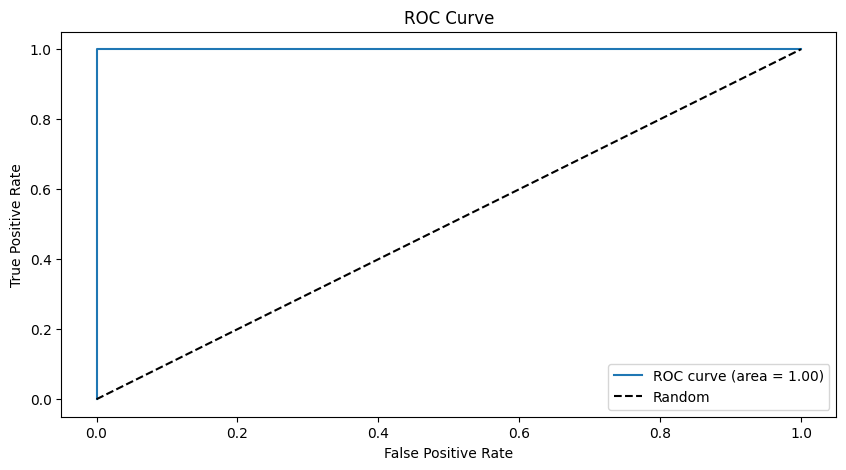

In [ ]:
# Grouping signals again as 2D images
labels = np.array(labels)
val_error = np.array(val_error)
labels_grouped = labels.reshape(-1, width)
val_error_grouped = val_error.reshape(-1, width)
labels_avg = labels_grouped.mean(axis=1)
val_error_avg = val_error_grouped.mean(axis=1)

# ROC Curve
fpr, tpr, thresholds = roc_curve(labels_avg, val_error_avg)
auc = roc_auc_score(labels_avg, val_error_avg)
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')  
plt.legend(loc='lower right')



# Compute statistics
group_clean = val_error_avg[labels_avg == 0]
group_inclusion = val_error_avg[labels_avg == 1]
def describe(name, group):
    print(f"\n{name}")
    print("-" * len(name))
    print(f"Count:     {len(group)}")
    print(f"Mean:      {np.mean(group):.4f}")
    print(f"Std dev:   {np.std(group):.4f}")
    print(f"Min:       {np.min(group):.4f}")
    print(f"Max:       {np.max(group):.4f}")
    print(f"Median:    {np.median(group):.4f}")
    print(f"Percentile 25/75: {np.percentile(group, 25):.4f} / {np.percentile(group, 75):.4f}")

describe("Clean Samples", group_clean) # From set_B1
describe("Inclusion Samples", group_inclusion) # From set_B2

In [92]:
'''
The code above is a simplified example of how to set up a VAE for 1D data, train it, and evaluate its performance on a test set.
The performance is evaluated using the ROC curve and AUC score, which are common metrics for binary classification tasks.
AUC = 1 indicates perfect classification, which is unlikely in real-world scenarios.
High AUC can be explained by the low difficulty of the task, as the model is trained on noise and then tested on a dataset with a clear difference (nodules).
'''

'\nThe code above is a simplified example of how to set up a VAE for 1D data, train it, and evaluate its performance on a test set.\nThe performance is evaluated using the ROC curve and AUC score, which are common metrics for binary classification tasks.\nAUC = 1 indicates perfect classification, which is unlikely in real-world scenarios.\nHigh AUC can be explained by the low difficulty of the task, as the model is trained on noise and then tested on a dataset with a clear difference (nodules).\n'